### Step 1: Load data

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from torchvision import transforms, models
from torch.utils.data import DataLoader
from ChestXRayDataset import ChestXRayDataset
from MultiSourceChestXRayDataset import MultiSourceChestXRayDataset
from skmultilearn.model_selection import IterativeStratification
from sklearn.metrics import classification_report, precision_recall_curve
from tqdm import tqdm

In [2]:
df_train = pd.read_csv('../data/data_entries/miccai2023_nih-cxr-lt_labels_train.csv')
df_val = pd.read_csv('../data/data_entries/miccai2023_nih-cxr-lt_labels_val.csv')
df_test = pd.read_csv('../data/data_entries/miccai2023_nih-cxr-lt_labels_test.csv')

In [3]:
df_train.shape, df_val.shape, df_test.shape

((78506, 22), (12533, 22), (21081, 22))

### Down sampling 'No Finding', 'Atelectasis', 'Effusion' and 'Infiltration'

In [4]:
categories_to_down_sample = {
    'Infiltration': 0.63,
    'Effusion': 0.4,
    'Atelectasis': 0.4,
    'No Finding': 0.95
}

In [5]:
# Before down sampling
for category in categories_to_down_sample.keys():
    print(f"Rows before down sampling for {category}: {df_train[category].sum()}")

Rows before down sampling for Infiltration: 12739
Rows before down sampling for Effusion: 7919
Rows before down sampling for Atelectasis: 7587
Rows before down sampling for No Finding: 44625


In [6]:
for category, frac in categories_to_down_sample.items():
    # Filter rows where the category has value 1
    rows_with_category = df_train[df_train[category] == 1]

    # Randomly select the specified fraction of those rows
    rows_to_drop = rows_with_category.sample(frac=frac, random_state=42)

    # Drop those rows from the original DataFrame
    df_train = df_train.drop(rows_to_drop.index)

In [7]:
# Remaining rows after down sampling
for category in categories_to_down_sample.keys():
    print(f"Remaining rows for {category}: {df_train[category].sum()}")

Remaining rows for Infiltration: 4155
Remaining rows for Effusion: 3545
Remaining rows for Atelectasis: 3475
Remaining rows for No Finding: 2231


Some images exist in images folder, but not in miccai labels and opposite

To fix this problem We create list of all image IDs in both train and test _images folder
then ensure that only images withing this list are loaded to dataset

In [8]:
image_dir_train = '../data/train_images'
image_dir_test = '../data/test_images'
# Define function to get valid image ids that exist in the image directory
def get_valid_image_ids(df, image_dir):
    # Get the set of image IDs that exist in the image directory
    image_files = set(os.listdir(image_dir))  # List of all files in the image directory
    # Check if image id exists in the image directory
    valid_ids = df[df['id'].isin(image_files)]['id']
    return valid_ids

In [9]:
# Get valid image ids for train and test datasets
valid_train_ids = get_valid_image_ids(df_train, image_dir_train)
valid_val_ids = get_valid_image_ids(df_val, image_dir_train)
valid_test_ids = get_valid_image_ids(df_test, image_dir_test)

In [10]:
# Filter the DataFrames to include only the valid image IDs
df_train_valid = df_train[df_train['id'].isin(valid_train_ids)]
df_val_valid = df_val[df_val['id'].isin(valid_val_ids)]
df_test_valid = df_test[df_test['id'].isin(valid_test_ids)]

df_train_valid.shape, df_val_valid.shape, df_test_valid.shape

((23164, 22), (8018, 22), (21081, 22))

In [11]:
df_train_val = pd.concat([df_train_valid, df_val_valid], ignore_index=True)
assert df_train_val.shape[0] == df_train_valid.shape[0] + df_val_valid.shape[0]

In [12]:
df_train_val = df_train_val.copy()
#df_train_val.drop(columns=['Pneumomediastinum', 'subj_id'], inplace=True)
# Labels such Pneumomediastinum and Hernia rarely appears, but we keep them to generlize the model
df_train_val.drop(columns=['subj_id'], inplace=True)
df_train_val.shape

(31182, 21)

In [13]:
## Do same for testing
df_test_valid = df_test_valid.copy()
df_test_valid.drop(columns=['subj_id'], inplace=True)
df_test_valid.shape

(21081, 21)

### Step 2: Label encoding and create target column 

#### Step 2.1: Check for Inconsistent Rows

First, we’ll check if any rows violate the condition: if No Finding is 1, then all other categories should be 0.

In [14]:
# For train data
inconsistent_rows = df_train_val[(df_train_val['No Finding'] == 1) & (df_train_val.iloc[:, 1:-1].sum(axis=1) > 0)]

print(inconsistent_rows)

Empty DataFrame
Columns: [id, Atelectasis, Cardiomegaly, Consolidation, Edema, Effusion, Emphysema, Fibrosis, Hernia, Infiltration, Mass, Nodule, Pleural Thickening, Pneumonia, Pneumothorax, Pneumoperitoneum, Pneumomediastinum, Subcutaneous Emphysema, Tortuous Aorta, Calcification of the Aorta, No Finding]
Index: []

[0 rows x 21 columns]


#### Step 2.2: create mappings variable for all categories we have

In [15]:
# Extract all categories (exclude 'id')
categories = df_train_val.columns[1:]

# Create a mapping dictionary for categories to numbers
category_mapping = {category: idx for idx, category in enumerate(categories)}

print("Category Mapping:")
print(category_mapping)

Category Mapping:
{'Atelectasis': 0, 'Cardiomegaly': 1, 'Consolidation': 2, 'Edema': 3, 'Effusion': 4, 'Emphysema': 5, 'Fibrosis': 6, 'Hernia': 7, 'Infiltration': 8, 'Mass': 9, 'Nodule': 10, 'Pleural Thickening': 11, 'Pneumonia': 12, 'Pneumothorax': 13, 'Pneumoperitoneum': 14, 'Pneumomediastinum': 15, 'Subcutaneous Emphysema': 16, 'Tortuous Aorta': 17, 'Calcification of the Aorta': 18, 'No Finding': 19}


### Step 2.3: Create finding column

This column will contain list of all finding categories for each image, and we have the following scenarios
1. The image has no sickness ==> finding column is a list with only one item 'No Finding'
2. The image contains only one category i.g 'Hernia' ==> finding column is a list with only one item 'Hernia'
3. The image contains more than one category i.g 'Hernia' and 'Edema'...etc. ==> finding column is a list finding items 'Hernia' and 'Edema'

In [16]:
# Function to create 'finding' and 'finding_encoded' as a string based on category values
def create_finding(row):
    # Check if 'No Finding' is 1, indicating no other categories are marked
    if row['No Finding'] == 1:
        return ['No Finding'], str(category_mapping['No Finding'])  # Return encoded as a string
    
    else:
        # Generate lists of findings and their encoded values
        findings = [category for category in categories if row[category] == 1]
        encoded_findings = [str(category_mapping[category]) for category in findings]
        
        # Join encoded findings as a single string for stratification
        return findings, ','.join(encoded_findings)


In [17]:
# Apply function to create 'finding' and 'finding_encoded' columns in train_val data
df_train_val[['finding', 'finding_encoded']] = df_train_val.apply(
    lambda row: pd.Series(create_finding(row)), axis=1
)

df_train_val[['id', 'finding', 'finding_encoded']]

,id,finding,finding_encoded
0,00000001_000.png,[Cardiomegaly],1
1,00000001_001.png,"[Cardiomegaly, Emphysema]","1,5"
2,00000001_002.png,"[Cardiomegaly, Effusion]","1,4"
3,00000004_000.png,"[Mass, Nodule]","9,10"
4,00000005_007.png,"[Effusion, Infiltration]","4,8"
...,...,...,...
31177,00030601_000.png,[Atelectasis],0
31178,00030661_000.png,[Atelectasis],0
31179,00030703_000.png,[Nodule],10
31180,00030703_001.png,[Nodule],10


In [18]:
# Apply function to create 'finding' and 'finding_encoded' columns in test data
df_test_valid[['finding', 'finding_encoded']] = df_test_valid.apply(
    lambda row: pd.Series(create_finding(row)), axis=1
)

df_test_valid[['id', 'finding', 'finding_encoded']]

,id,finding,finding_encoded
0,00000013_000.png,[No Finding],19
1,00000013_001.png,"[Emphysema, Pneumothorax, Subcutaneous Emphysema]","5,13,16"
2,00000013_002.png,"[Emphysema, Pneumothorax, Subcutaneous Emphysema]","5,13,16"
3,00000013_003.png,[Pleural Thickening],11
4,00000013_004.png,"[Effusion, Emphysema, Infiltration, Pneumothor...","4,5,8,13,16"
...,...,...,...
21076,00030800_000.png,[No Finding],19
21077,00030802_000.png,[No Finding],19
21078,00030803_000.png,[No Finding],19
21079,00030804_000.png,[No Finding],19


### 2.4 Create train_augmented df and concat it with df_train_val

In [19]:
train_augmented_df = pd.read_csv('../data/data_entries/augmented_images_v3.csv')
print(f"Augmented df shape: {train_augmented_df.shape}")

# Add `is_augmented` flag to distinguish between datasets
df_train_val['is_augmented'] = False
train_augmented_df['is_augmented'] = True

# Concatenate both DataFrames
combined_df = pd.concat([df_train_val, train_augmented_df], ignore_index=True)
assert combined_df.shape[0] == df_train_val.shape[0] + train_augmented_df.shape[0]


Augmented df shape: (13731, 23)


In [20]:
print(f"Combined df shape: {combined_df.shape}")

Combined df shape: (44913, 24)


### Step 3: Create subsets and DataLoaders for the training, validation, and test sets

In [21]:
# Image transformation for training and validation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [22]:
subset_ratio = 0.99 # start with 30% of data
train_val_ratio = 0.8 # For train, val ratio

#### Step 3.1 Take a Stratified 30% Subset Based on finding_encoded
We use: **from skmultilearn.model_selection import IterativeStratification**
For multi-label classification (where each image can belong to one or more categories), the best choice would be:

from skmultilearn.model_selection import IterativeStratification since it is specifically tailored for multi-label classification tasks and will ensure proper stratified splitting with regard to your multiple sickness categories.

[Reference about iterstrat.ml_stratifiers](https://medium.com/gumgum-tech/creating-balanced-multi-label-datasets-for-model-training-and-evaluation-16b6a3a2d912)

**First: create the subset**

In [23]:
label_matrix = combined_df['finding_encoded'].str.get_dummies(sep=',')

# Initialize IterativeStratification
stratifier = IterativeStratification(n_splits=2, order=1, sample_distribution_per_fold=[subset_ratio, 1 - subset_ratio]) # 1 - 0.3 = 0.7

# Perform the stratified split
train_indices, subset_indices = next(stratifier.split(combined_df, label_matrix))

# Create the subset and remaining dataframes
subset_combined_df = combined_df.iloc[subset_indices].reset_index(drop=True)
remaining_combined_df = combined_df.iloc[train_indices].reset_index(drop=True)

In [24]:
# After the first stratified split (Subset and Remaining)
initial_size = len(combined_df)
print(f"Initial size of combined_df: {initial_size} rows")

subset_size = len(subset_combined_df)
remaining_size = len(remaining_combined_df)
print(f"Subset size for training (80%): {subset_size} rows")
print(f"Remaining size not used (20%): {remaining_size} rows")

Initial size of combined_df: 44913 rows
Subset size for training (80%): 44454 rows
Remaining size not used (20%): 459 rows


In [25]:
assert initial_size == subset_size + remaining_size

In [26]:
subset_combined_df.shape

(44454, 24)

**Then: split to train, val**

In [27]:
# Perform the stratified split
label_matrix_2 = subset_combined_df['finding_encoded'].str.get_dummies(sep=',')
stratifier_2 = IterativeStratification(n_splits=2, order=1, sample_distribution_per_fold=[train_val_ratio, 1 - train_val_ratio]) 
val_indices, train_indices = next(stratifier_2.split(subset_combined_df, label_matrix_2))

train_df = subset_combined_df.iloc[train_indices].reset_index(drop=True)
val_df = subset_combined_df.iloc[val_indices].reset_index(drop=True)

# Verify the sizes
print(f"Train size (80% of subset): {len(train_df)} rows")
print(f"Val size (20% of subset): {len(val_df)} rows")

Train size (80% of subset): 35698 rows
Val size (20% of subset): 8756 rows


#### Step 3.2: Create dataset objects


In [28]:
# Define image directories
image_dirs = {
    'train': '../data/train_images',
    'augmented': '../data/oversampled_train'
}

In [29]:
train_dataset = MultiSourceChestXRayDataset(
    dataframe=train_df,
    image_dirs=image_dirs,
    category_mapping=category_mapping,
    transform=train_transform,
    augment_transform=train_transform
)

val_dataset = MultiSourceChestXRayDataset(
    dataframe=val_df,
    image_dirs=image_dirs,
    category_mapping=category_mapping,
    transform=val_transform,
    augment_transform=val_transform
)

# Create Dataset for df_test_valid (since it's small, we don't need to subset)
test_dataset = ChestXRayDataset(dataframe=df_test_valid, image_dir=image_dir_test, category_mapping=category_mapping, transform=val_transform)

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


#### Step 3.3: Create dataloaders

In [30]:
# Create Dataloaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [31]:
print(f"Training DataLoader: {len(train_loader)} batches")
print(f"Validation DataLoader: {len(val_loader)} batches")
print(f"Testing DataLoader: {len(test_loader)} batches")

Training DataLoader: 1116 batches
Validation DataLoader: 274 batches
Testing DataLoader: 659 batches


### Step 4: Define the model
We use pretrained ResNet
- We add linear layer to predict multi-label ( more than one category per image)
- ResNet-50 designed to output 2048 features
- We add two Linear layer to avoid going down from 2048 features to only 20 which may cause instability and overfitting

**Note**: Different additional params/functionality to the network i.g Dropout, normalization...etc. have been tested

In [32]:
# Number of unique categories (labels) in the 'finding_encoded' column
num_classes = len(combined_df['finding_encoded'].str.get_dummies(sep=',').columns)
print(num_classes)

20


In [33]:
model = models.resnet50(weights='IMAGENET1K_V2') 
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),  # to reduce complexity gradually (2048, 512)
    nn.BatchNorm1d(512),
    nn.ReLU(), 
    nn.Dropout(0.4),
    nn.Linear(512, 256), 
    nn.BatchNorm1d(256),
    nn.ReLU(), 
    nn.Dropout(0.4),
    nn.Linear(256, num_classes),  # Exclude 'id', 20 different categories
    nn.Sigmoid()  # Sigmoid for multi-label classification
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model.to(device)

cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Step 5: Train, Validate and test the model

[Referance about BCEWithLogitsLoss()](https://medium.com/@sahilcarterr/why-nn-bcewithlogitsloss-numerically-stable-6a04f3052967)

nn.BCEWithLogitsLoss():

1. This loss function is more efficient because it combines the sigmoid activation and binary cross-entropy loss into a single function.
2. It expects the raw logits (not passed through sigmoid) as input and applies the sigmoid internally.
3. It's numerically more stable and faster than using nn.BCELoss() with a separate sigmoid.

nn.BCELoss():

1. This loss function expects the model's output to be probabilities in the range [0, 1], so it requires you to apply a sigmoid activation to the model's output beforehand.
2. The formula for binary cross-entropy is applied after transforming the raw logits into probabilities using the sigmoid function.

***Define weighted classes***

In [34]:
categories  = train_df['finding_encoded'].str.split(',').explode().value_counts()
categories.index = categories.index.astype(int)
categories = categories.sort_index()
categories

finding_encoded
0     3301
1     1337
2     1582
3     2129
4     3394
5     2796
6     2698
7      886
8     4117
9     2574
10    3023
11    1852
12    1330
13    1704
14     956
15     315
16    1698
17    1806
18    1346
19    5822
Name: count, dtype: int64

In [35]:
total = len(train_df)
total

35698

In [36]:
proportions =  categories / total
proportions

finding_encoded
0     0.092470
1     0.037453
2     0.044316
3     0.059639
4     0.095075
5     0.078324
6     0.075578
7     0.024819
8     0.115329
9     0.072105
10    0.084683
11    0.051880
12    0.037257
13    0.047734
14    0.026780
15    0.008824
16    0.047566
17    0.050591
18    0.037705
19    0.163090
Name: count, dtype: float64

In [37]:
weights = 1 / proportions
weights

finding_encoded
0      10.814299
1      26.700075
2      22.565107
3      16.767496
4      10.517973
5      12.767525
6      13.231282
7      40.291196
8       8.670877
9      13.868687
10     11.808799
11     19.275378
12     26.840602
13     20.949531
14     37.341004
15    113.326984
16     21.023557
17     19.766334
18     26.521545
19      6.131570
Name: count, dtype: float64

In [38]:
normalized_weights = weights / weights.sum()
normalized_weights

finding_encoded
0     0.022568
1     0.055720
2     0.047091
3     0.034992
4     0.021950
5     0.026645
6     0.027612
7     0.084084
8     0.018095
9     0.028943
10    0.024644
11    0.040226
12    0.056014
13    0.043720
14    0.077927
15    0.236502
16    0.043874
17    0.041250
18    0.055348
19    0.012796
Name: count, dtype: float64

In [39]:
weights_tensor = torch.tensor(weights.values, dtype=torch.float32).to(device)
weights_tensor

tensor([ 10.8143,  26.7001,  22.5651,  16.7675,  10.5180,  12.7675,  13.2313,
         40.2912,   8.6709,  13.8687,  11.8088,  19.2754,  26.8406,  20.9495,
         37.3410, 113.3270,  21.0236,  19.7663,  26.5215,   6.1316],
       device='cuda:0')

In [40]:
# Use BCEWithLogitsLoss for multi-label classification
criterion = nn.BCEWithLogitsLoss(pos_weight=weights_tensor)   # Combined Sigmoid + Binary Cross-Entropy Loss

In [41]:
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9) 

In [42]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9) 
#lookahead_optimizer = optim_mod.Lookahead(optimizer, k=5, alpha=0.5)

#scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.7)

In [43]:
# Initialize lists to store loss and accuracy per epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

threshold = 0.5

In [44]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels, _ in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels.float())
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        all_preds.append(torch.sigmoid(outputs).detach().cpu())
        all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()
    
    # Print each label, prediction, and corresponding pos_weight (for debug and ensure everything as excepted)
        #preds = torch.sigmoid(outputs).detach().cpu()
        #for i in range(len(labels)):  # Loop through each image in the batch
            #label = labels[i].cpu().numpy()
            #pred = preds[i].numpy()
            #print(f"Label: {label}, Prediction: {pred}, Pos_Weight: {weights_tensor.cpu().numpy()}")

    # Calculate F1 scores and thresholds for each class
    best_thresholds = []
    for i in range(all_labels.shape[1]):
        precision, recall, thresholds = precision_recall_curve(all_labels[:, i], all_preds[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_threshold = thresholds[np.argmax(f1_scores)]
        best_thresholds.append(best_threshold)

    # Apply class-specific thresholds
    thresholded_preds = np.column_stack([(all_preds[:, i] > best_thresholds[i]).astype(float) for i in range(all_labels.shape[1])])

    correct_predictions = (thresholded_preds == all_labels).all(axis=1).sum()
    avg_loss = running_loss / len(dataloader)
    avg_accuracy = (correct_predictions / all_labels.shape[0]) * 100

    report = classification_report(all_labels, thresholded_preds, zero_division=0, output_dict=True)
    precision, recall, f1 = report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score']

    return avg_loss, avg_accuracy, precision, recall, f1, best_thresholds, correct_predictions


In [45]:
def validate(model, dataloader, criterion, device, best_thresholds):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels, _ in tqdm(dataloader, desc="Validating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.float())
            running_loss += loss.item()

            all_preds.append(torch.sigmoid(outputs).cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Apply class-specific thresholds
    thresholded_preds = np.column_stack([(all_preds[:, i] > best_thresholds[i]).astype(float) for i in range(all_labels.shape[1])])

    correct_predictions = (thresholded_preds == all_labels).all(axis=1).sum()
    avg_loss = running_loss / len(dataloader)
    avg_accuracy = (correct_predictions / all_labels.shape[0]) * 100

    report = classification_report(all_labels, thresholded_preds, zero_division=0, output_dict=True)
    precision, recall, f1 = report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score']

    return avg_loss, avg_accuracy, precision, recall, f1, correct_predictions

In [46]:
def test(model, dataloader, criterion, device, label_names, best_thresholds):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels, _ in tqdm(dataloader, desc="Testing"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.float())
            running_loss += loss.item()

            all_preds.append(torch.sigmoid(outputs).cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Dynamic threshold for each label based on train data
    thresholded_preds = np.column_stack([(all_preds[:, i] > best_thresholds[i]).astype(float) for i in range(all_labels.shape[1])])

    print("\nFinding Best Thresholds for Each Class (Reported Only):")
    for i, threshold in enumerate(best_thresholds):
        print(f"Class '{label_names[i]}': Best Threshold = {threshold:.4f}")

    default_preds = (all_preds > 0.5).astype(float)

    print("\nClassification Report with Best Thresholds:")
    report_best = classification_report(all_labels, thresholded_preds, target_names=label_names, zero_division=0)
    print(report_best)

    print("\nClassification Report with Default Threshold (0.5):")
    report_default = classification_report(all_labels, default_preds, target_names=label_names, zero_division=0)
    print(report_default)

    avg_loss = running_loss / len(dataloader)

    return avg_loss, report_best, report_default, best_thresholds

In [47]:
num_epochs = 100

# Early stopping parameters
patience = 7 # wait 
best_val = float("inf")
epochs_no_improve = 0

# for plotting
num_epochs_runned = 0

In [48]:
for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    
    # Train the model for one epoch
    train_loss, train_accuracy, train_precision, train_recall, train_f1, train_best_threshold, train_correct_predictions = train(model, train_loader, criterion, optimizer, device)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
      f"Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, "
      f"Train F1: {train_f1:.4f}, Train Best Threshold: {train_best_threshold:.4f}, "
      f"Train correct predictions: {train_correct_predictions}")



    # Validate the model after training
    val_loss, val_accuracy, val_precision, val_recall, val_f1, val_correct_predictions = validate(model, val_loader, criterion, device, train_best_threshold)

    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, "
      f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, "
      f"Val F1: {val_f1:.4f}, Val correct predictions: {val_correct_predictions}")


    # Step the Lookahead optimizer
    #lookahead_optimizer.step()
    # Step the ReduceLROnPlateau scheduler
    #scheduler.step(val_loss)
    
    scheduler.step()

    print(f"Epoch {epoch + 1}: Learning rate = {scheduler.get_last_lr()[0]}")

    num_epochs_runned += 1

    # Validation loss has improved
    if val_loss < best_val:
        best_val = val_loss
        epochs_no_improve = 0  # Reset the counter if we see improvement
        
        # Save the model checkpoint
        torch.save(model.state_dict(), "singular_over_down_sampled.pth")
        print("Model improved and saved.")
    else:
        print("Model did not improved")
        epochs_no_improve += 1  # Increment counter if no improvement

    # Early stopping
    if epochs_no_improve == patience:
        print("Early stopping triggered")
        break

    print("-" * 60)

Epoch [1/100]


Training: 100%|██████████| 1116/1116 [02:51<00:00,  6.50it/s]


Train Loss: 1.2955, Train Accuracy: 1.4707, Train Precision: 0.1045, Train Recall: 0.4165, Train F1: 0.1558, Train Best Threshold: 0.5848, Train correct predictions: 525


Validating: 100%|██████████| 274/274 [00:43<00:00,  6.34it/s]


Total prediction: 8756  Correct preds: 22  all labels size: (8756, 20)
Val Loss: 1.2937, Val Accuracy: 0.2513, Val Precision: 0.1137, Val Recall: 0.4913, Val F1: 0.1680, Val correct predictions: 22
Epoch 1: Learning rate = 0.001
Model improved and saved.
------------------------------------------------------------
Epoch [2/100]


Training: 100%|██████████| 1116/1116 [02:51<00:00,  6.51it/s]


Train Loss: 1.2675, Train Accuracy: 5.3869, Train Precision: 0.1370, Train Recall: 0.3907, Train F1: 0.1855, Train Best Threshold: 0.6432, Train correct predictions: 1923


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.42it/s]


Total prediction: 8756  Correct preds: 477  all labels size: (8756, 20)
Val Loss: 1.2656, Val Accuracy: 5.4477, Val Precision: 0.1457, Val Recall: 0.4539, Val F1: 0.2017, Val correct predictions: 477
Epoch 2: Learning rate = 0.001
Model improved and saved.
------------------------------------------------------------
Epoch [3/100]


Training: 100%|██████████| 1116/1116 [02:52<00:00,  6.46it/s]


Train Loss: 1.2459, Train Accuracy: 6.5130, Train Precision: 0.1582, Train Recall: 0.4221, Train F1: 0.2112, Train Best Threshold: 0.6696, Train correct predictions: 2325


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.41it/s]


Total prediction: 8756  Correct preds: 51  all labels size: (8756, 20)
Val Loss: 1.3122, Val Accuracy: 0.5825, Val Precision: 0.1310, Val Recall: 0.3931, Val F1: 0.1577, Val correct predictions: 51
Epoch 3: Learning rate = 0.001
Model did not improved
------------------------------------------------------------
Epoch [4/100]


Training: 100%|██████████| 1116/1116 [02:51<00:00,  6.49it/s]


Train Loss: 1.2344, Train Accuracy: 7.2945, Train Precision: 0.1767, Train Recall: 0.4196, Train F1: 0.2290, Train Best Threshold: 0.6895, Train correct predictions: 2604


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.44it/s]


Total prediction: 8756  Correct preds: 328  all labels size: (8756, 20)
Val Loss: 1.2665, Val Accuracy: 3.7460, Val Precision: 0.1526, Val Recall: 0.4172, Val F1: 0.1979, Val correct predictions: 328
Epoch 4: Learning rate = 0.001
Model did not improved
------------------------------------------------------------
Epoch [5/100]


Training: 100%|██████████| 1116/1116 [02:52<00:00,  6.45it/s]


Train Loss: 1.2238, Train Accuracy: 7.0760, Train Precision: 0.1850, Train Recall: 0.4493, Train F1: 0.2432, Train Best Threshold: 0.6939, Train correct predictions: 2526


Validating: 100%|██████████| 274/274 [00:43<00:00,  6.37it/s]


Total prediction: 8756  Correct preds: 670  all labels size: (8756, 20)
Val Loss: 1.2449, Val Accuracy: 7.6519, Val Precision: 0.1954, Val Recall: 0.4446, Val F1: 0.2508, Val correct predictions: 670
Epoch 5: Learning rate = 0.0009000000000000001
Model improved and saved.
------------------------------------------------------------
Epoch [6/100]


Training: 100%|██████████| 1116/1116 [02:52<00:00,  6.45it/s]


Train Loss: 1.2085, Train Accuracy: 8.7820, Train Precision: 0.2123, Train Recall: 0.4561, Train F1: 0.2708, Train Best Threshold: 0.7069, Train correct predictions: 3135


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.45it/s]


Total prediction: 8756  Correct preds: 778  all labels size: (8756, 20)
Val Loss: 1.2269, Val Accuracy: 8.8853, Val Precision: 0.2280, Val Recall: 0.4277, Val F1: 0.2708, Val correct predictions: 778
Epoch 6: Learning rate = 0.0009000000000000001
Model improved and saved.
------------------------------------------------------------
Epoch [7/100]


Training: 100%|██████████| 1116/1116 [02:51<00:00,  6.50it/s]


Train Loss: 1.1988, Train Accuracy: 9.5804, Train Precision: 0.2289, Train Recall: 0.4765, Train F1: 0.2905, Train Best Threshold: 0.7100, Train correct predictions: 3420


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.42it/s]


Total prediction: 8756  Correct preds: 548  all labels size: (8756, 20)
Val Loss: 1.2325, Val Accuracy: 6.2586, Val Precision: 0.2147, Val Recall: 0.4536, Val F1: 0.2467, Val correct predictions: 548
Epoch 7: Learning rate = 0.0009000000000000001
Model did not improved
------------------------------------------------------------
Epoch [8/100]


Training: 100%|██████████| 1116/1116 [02:53<00:00,  6.44it/s]


Train Loss: 1.1907, Train Accuracy: 10.9782, Train Precision: 0.2514, Train Recall: 0.4749, Train F1: 0.3095, Train Best Threshold: 0.7166, Train correct predictions: 3919


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.46it/s]


Total prediction: 8756  Correct preds: 624  all labels size: (8756, 20)
Val Loss: 1.2190, Val Accuracy: 7.1265, Val Precision: 0.2451, Val Recall: 0.4525, Val F1: 0.2851, Val correct predictions: 624
Epoch 8: Learning rate = 0.0009000000000000001
Model improved and saved.
------------------------------------------------------------
Epoch [9/100]


Training: 100%|██████████| 1116/1116 [02:51<00:00,  6.49it/s]


Train Loss: 1.1821, Train Accuracy: 11.4208, Train Precision: 0.2678, Train Recall: 0.4947, Train F1: 0.3279, Train Best Threshold: 0.7171, Train correct predictions: 4077


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.40it/s]


Total prediction: 8756  Correct preds: 632  all labels size: (8756, 20)
Val Loss: 1.2142, Val Accuracy: 7.2179, Val Precision: 0.2742, Val Recall: 0.4570, Val F1: 0.3023, Val correct predictions: 632
Epoch 9: Learning rate = 0.0009000000000000001
Model improved and saved.
------------------------------------------------------------
Epoch [10/100]


Training: 100%|██████████| 1116/1116 [02:51<00:00,  6.49it/s]


Train Loss: 1.1733, Train Accuracy: 13.1576, Train Precision: 0.2961, Train Recall: 0.4913, Train F1: 0.3517, Train Best Threshold: 0.7223, Train correct predictions: 4697


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.44it/s]


Total prediction: 8756  Correct preds: 972  all labels size: (8756, 20)
Val Loss: 1.2087, Val Accuracy: 11.1010, Val Precision: 0.3022, Val Recall: 0.4136, Val F1: 0.3205, Val correct predictions: 972
Epoch 10: Learning rate = 0.0008100000000000001
Model improved and saved.
------------------------------------------------------------
Epoch [11/100]


Training: 100%|██████████| 1116/1116 [02:52<00:00,  6.46it/s]


Train Loss: 1.1642, Train Accuracy: 13.5246, Train Precision: 0.3166, Train Recall: 0.5221, Train F1: 0.3781, Train Best Threshold: 0.7212, Train correct predictions: 4828


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.38it/s]


Total prediction: 8756  Correct preds: 1089  all labels size: (8756, 20)
Val Loss: 1.1901, Val Accuracy: 12.4372, Val Precision: 0.3258, Val Recall: 0.4829, Val F1: 0.3564, Val correct predictions: 1089
Epoch 11: Learning rate = 0.0008100000000000001
Model improved and saved.
------------------------------------------------------------
Epoch [12/100]


Training: 100%|██████████| 1116/1116 [02:51<00:00,  6.52it/s]


Train Loss: 1.1564, Train Accuracy: 16.2054, Train Precision: 0.3452, Train Recall: 0.5243, Train F1: 0.4017, Train Best Threshold: 0.7239, Train correct predictions: 5785


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.46it/s]


Total prediction: 8756  Correct preds: 1448  all labels size: (8756, 20)
Val Loss: 1.1797, Val Accuracy: 16.5372, Val Precision: 0.3650, Val Recall: 0.5081, Val F1: 0.4055, Val correct predictions: 1448
Epoch 12: Learning rate = 0.0008100000000000001
Model improved and saved.
------------------------------------------------------------
Epoch [13/100]


Training: 100%|██████████| 1116/1116 [02:51<00:00,  6.49it/s]


Train Loss: 1.1525, Train Accuracy: 17.9758, Train Precision: 0.3697, Train Recall: 0.5229, Train F1: 0.4166, Train Best Threshold: 0.7260, Train correct predictions: 6417


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.44it/s]


Total prediction: 8756  Correct preds: 1405  all labels size: (8756, 20)
Val Loss: 1.1773, Val Accuracy: 16.0461, Val Precision: 0.3657, Val Recall: 0.4932, Val F1: 0.4029, Val correct predictions: 1405
Epoch 13: Learning rate = 0.0008100000000000001
Model improved and saved.
------------------------------------------------------------
Epoch [14/100]


Training: 100%|██████████| 1116/1116 [02:52<00:00,  6.47it/s]


Train Loss: 1.1442, Train Accuracy: 18.9030, Train Precision: 0.3833, Train Recall: 0.5455, Train F1: 0.4352, Train Best Threshold: 0.7256, Train correct predictions: 6748


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.46it/s]


Total prediction: 8756  Correct preds: 1494  all labels size: (8756, 20)
Val Loss: 1.1744, Val Accuracy: 17.0626, Val Precision: 0.3540, Val Recall: 0.5024, Val F1: 0.3940, Val correct predictions: 1494
Epoch 14: Learning rate = 0.0008100000000000001
Model improved and saved.
------------------------------------------------------------
Epoch [15/100]


Training: 100%|██████████| 1116/1116 [02:52<00:00,  6.47it/s]


Train Loss: 1.1397, Train Accuracy: 20.7463, Train Precision: 0.4008, Train Recall: 0.5454, Train F1: 0.4456, Train Best Threshold: 0.7267, Train correct predictions: 7406


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.45it/s]


Total prediction: 8756  Correct preds: 1527  all labels size: (8756, 20)
Val Loss: 1.1775, Val Accuracy: 17.4395, Val Precision: 0.3966, Val Recall: 0.4905, Val F1: 0.4120, Val correct predictions: 1527
Epoch 15: Learning rate = 0.000729
Model did not improved
------------------------------------------------------------
Epoch [16/100]


Training: 100%|██████████| 1116/1116 [02:51<00:00,  6.51it/s]


Train Loss: 1.1311, Train Accuracy: 23.1414, Train Precision: 0.4256, Train Recall: 0.5586, Train F1: 0.4683, Train Best Threshold: 0.7275, Train correct predictions: 8261


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.48it/s]


Total prediction: 8756  Correct preds: 1742  all labels size: (8756, 20)
Val Loss: 1.1719, Val Accuracy: 19.8949, Val Precision: 0.3960, Val Recall: 0.4869, Val F1: 0.4092, Val correct predictions: 1742
Epoch 16: Learning rate = 0.000729
Model improved and saved.
------------------------------------------------------------
Epoch [17/100]


Training: 100%|██████████| 1116/1116 [02:52<00:00,  6.47it/s]


Train Loss: 1.1249, Train Accuracy: 24.6596, Train Precision: 0.4435, Train Recall: 0.5787, Train F1: 0.4897, Train Best Threshold: 0.7271, Train correct predictions: 8803


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.45it/s]


Total prediction: 8756  Correct preds: 1768  all labels size: (8756, 20)
Val Loss: 1.1642, Val Accuracy: 20.1919, Val Precision: 0.4357, Val Recall: 0.5169, Val F1: 0.4516, Val correct predictions: 1768
Epoch 17: Learning rate = 0.000729
Model improved and saved.
------------------------------------------------------------
Epoch [18/100]


Training: 100%|██████████| 1116/1116 [02:52<00:00,  6.45it/s]


Train Loss: 1.1211, Train Accuracy: 26.1667, Train Precision: 0.4622, Train Recall: 0.5754, Train F1: 0.5010, Train Best Threshold: 0.7282, Train correct predictions: 9341


Validating: 100%|██████████| 274/274 [00:43<00:00,  6.32it/s]


Total prediction: 8756  Correct preds: 1740  all labels size: (8756, 20)
Val Loss: 1.1671, Val Accuracy: 19.8721, Val Precision: 0.4225, Val Recall: 0.5133, Val F1: 0.4392, Val correct predictions: 1740
Epoch 18: Learning rate = 0.000729
Model did not improved
------------------------------------------------------------
Epoch [19/100]


Training: 100%|██████████| 1116/1116 [02:51<00:00,  6.52it/s]


Train Loss: 1.1164, Train Accuracy: 27.0715, Train Precision: 0.4672, Train Recall: 0.5991, Train F1: 0.5143, Train Best Threshold: 0.7277, Train correct predictions: 9664


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.41it/s]


Total prediction: 8756  Correct preds: 1982  all labels size: (8756, 20)
Val Loss: 1.1629, Val Accuracy: 22.6359, Val Precision: 0.4245, Val Recall: 0.5255, Val F1: 0.4531, Val correct predictions: 1982
Epoch 19: Learning rate = 0.000729
Model improved and saved.
------------------------------------------------------------
Epoch [20/100]


Training: 100%|██████████| 1116/1116 [02:51<00:00,  6.51it/s]


Train Loss: 1.1119, Train Accuracy: 28.5982, Train Precision: 0.4796, Train Recall: 0.6037, Train F1: 0.5257, Train Best Threshold: 0.7282, Train correct predictions: 10209


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.43it/s]


Total prediction: 8756  Correct preds: 2046  all labels size: (8756, 20)
Val Loss: 1.1582, Val Accuracy: 23.3668, Val Precision: 0.4423, Val Recall: 0.5315, Val F1: 0.4703, Val correct predictions: 2046
Epoch 20: Learning rate = 0.0006561000000000001
Model improved and saved.
------------------------------------------------------------
Epoch [21/100]


Training: 100%|██████████| 1116/1116 [02:51<00:00,  6.52it/s]


Train Loss: 1.1060, Train Accuracy: 30.1473, Train Precision: 0.5051, Train Recall: 0.6242, Train F1: 0.5500, Train Best Threshold: 0.7280, Train correct predictions: 10762


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.44it/s]


Total prediction: 8756  Correct preds: 2224  all labels size: (8756, 20)
Val Loss: 1.1547, Val Accuracy: 25.3997, Val Precision: 0.4677, Val Recall: 0.5390, Val F1: 0.4901, Val correct predictions: 2224
Epoch 21: Learning rate = 0.0006561000000000001
Model improved and saved.
------------------------------------------------------------
Epoch [22/100]


Training: 100%|██████████| 1116/1116 [02:51<00:00,  6.51it/s]


Train Loss: 1.1010, Train Accuracy: 31.9346, Train Precision: 0.5258, Train Recall: 0.6299, Train F1: 0.5651, Train Best Threshold: 0.7283, Train correct predictions: 11400


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.44it/s]


Total prediction: 8756  Correct preds: 2163  all labels size: (8756, 20)
Val Loss: 1.1605, Val Accuracy: 24.7031, Val Precision: 0.4495, Val Recall: 0.5169, Val F1: 0.4624, Val correct predictions: 2163
Epoch 22: Learning rate = 0.0006561000000000001
Model did not improved
------------------------------------------------------------
Epoch [23/100]


Training: 100%|██████████| 1116/1116 [02:53<00:00,  6.45it/s]


Train Loss: 1.0982, Train Accuracy: 32.1811, Train Precision: 0.5302, Train Recall: 0.6499, Train F1: 0.5774, Train Best Threshold: 0.7273, Train correct predictions: 11488


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.49it/s]


Total prediction: 8756  Correct preds: 2232  all labels size: (8756, 20)
Val Loss: 1.1566, Val Accuracy: 25.4911, Val Precision: 0.4441, Val Recall: 0.5371, Val F1: 0.4686, Val correct predictions: 2232
Epoch 23: Learning rate = 0.0006561000000000001
Model did not improved
------------------------------------------------------------
Epoch [24/100]


Training: 100%|██████████| 1116/1116 [02:52<00:00,  6.47it/s]


Train Loss: 1.0943, Train Accuracy: 34.1420, Train Precision: 0.5541, Train Recall: 0.6386, Train F1: 0.5864, Train Best Threshold: 0.7289, Train correct predictions: 12188


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.45it/s]


Total prediction: 8756  Correct preds: 2263  all labels size: (8756, 20)
Val Loss: 1.1615, Val Accuracy: 25.8451, Val Precision: 0.4934, Val Recall: 0.5124, Val F1: 0.4853, Val correct predictions: 2263
Epoch 24: Learning rate = 0.0006561000000000001
Model did not improved
------------------------------------------------------------
Epoch [25/100]


Training: 100%|██████████| 1116/1116 [02:52<00:00,  6.49it/s]


Train Loss: 1.0939, Train Accuracy: 34.6014, Train Precision: 0.5558, Train Recall: 0.6415, Train F1: 0.5881, Train Best Threshold: 0.7290, Train correct predictions: 12352


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.46it/s]


Total prediction: 8756  Correct preds: 2513  all labels size: (8756, 20)
Val Loss: 1.1541, Val Accuracy: 28.7003, Val Precision: 0.4854, Val Recall: 0.5233, Val F1: 0.4932, Val correct predictions: 2513
Epoch 25: Learning rate = 0.00059049
Model improved and saved.
------------------------------------------------------------
Epoch [26/100]


Training: 100%|██████████| 1116/1116 [02:51<00:00,  6.52it/s]


Train Loss: 1.0879, Train Accuracy: 35.4053, Train Precision: 0.5662, Train Recall: 0.6690, Train F1: 0.6076, Train Best Threshold: 0.7281, Train correct predictions: 12639


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.44it/s]


Total prediction: 8756  Correct preds: 2515  all labels size: (8756, 20)
Val Loss: 1.1506, Val Accuracy: 28.7232, Val Precision: 0.4976, Val Recall: 0.5488, Val F1: 0.5093, Val correct predictions: 2515
Epoch 26: Learning rate = 0.00059049
Model improved and saved.
------------------------------------------------------------
Epoch [27/100]


Training: 100%|██████████| 1116/1116 [02:51<00:00,  6.51it/s]


Train Loss: 1.0831, Train Accuracy: 37.4811, Train Precision: 0.5967, Train Recall: 0.6708, Train F1: 0.6259, Train Best Threshold: 0.7290, Train correct predictions: 13380


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.48it/s]


Total prediction: 8756  Correct preds: 2571  all labels size: (8756, 20)
Val Loss: 1.1523, Val Accuracy: 29.3627, Val Precision: 0.5098, Val Recall: 0.5223, Val F1: 0.5062, Val correct predictions: 2571
Epoch 27: Learning rate = 0.00059049
Model did not improved
------------------------------------------------------------
Epoch [28/100]


Training: 100%|██████████| 1116/1116 [02:51<00:00,  6.49it/s]


Train Loss: 1.0809, Train Accuracy: 37.8256, Train Precision: 0.5967, Train Recall: 0.6775, Train F1: 0.6295, Train Best Threshold: 0.7289, Train correct predictions: 13503


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.46it/s]


Total prediction: 8756  Correct preds: 2744  all labels size: (8756, 20)
Val Loss: 1.1529, Val Accuracy: 31.3385, Val Precision: 0.5170, Val Recall: 0.5190, Val F1: 0.5105, Val correct predictions: 2744
Epoch 28: Learning rate = 0.00059049
Model did not improved
------------------------------------------------------------
Epoch [29/100]


Training: 100%|██████████| 1116/1116 [02:51<00:00,  6.51it/s]


Train Loss: 1.0790, Train Accuracy: 38.4643, Train Precision: 0.6067, Train Recall: 0.6915, Train F1: 0.6412, Train Best Threshold: 0.7285, Train correct predictions: 13731


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.40it/s]


Total prediction: 8756  Correct preds: 2609  all labels size: (8756, 20)
Val Loss: 1.1546, Val Accuracy: 29.7967, Val Precision: 0.5130, Val Recall: 0.5326, Val F1: 0.5127, Val correct predictions: 2609
Epoch 29: Learning rate = 0.00059049
Model did not improved
------------------------------------------------------------
Epoch [30/100]


Training: 100%|██████████| 1116/1116 [02:52<00:00,  6.49it/s]


Train Loss: 1.0757, Train Accuracy: 39.3944, Train Precision: 0.6240, Train Recall: 0.6851, Train F1: 0.6482, Train Best Threshold: 0.7294, Train correct predictions: 14063


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.46it/s]


Total prediction: 8756  Correct preds: 2532  all labels size: (8756, 20)
Val Loss: 1.1513, Val Accuracy: 28.9173, Val Precision: 0.5270, Val Recall: 0.5301, Val F1: 0.5150, Val correct predictions: 2532
Epoch 30: Learning rate = 0.000531441
Model did not improved
------------------------------------------------------------
Epoch [31/100]


Training: 100%|██████████| 1116/1116 [02:52<00:00,  6.49it/s]


Train Loss: 1.0732, Train Accuracy: 40.5121, Train Precision: 0.6223, Train Recall: 0.6951, Train F1: 0.6512, Train Best Threshold: 0.7292, Train correct predictions: 14462


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.46it/s]


Total prediction: 8756  Correct preds: 2729  all labels size: (8756, 20)
Val Loss: 1.1474, Val Accuracy: 31.1672, Val Precision: 0.5202, Val Recall: 0.5288, Val F1: 0.5147, Val correct predictions: 2729
Epoch 31: Learning rate = 0.000531441
Model improved and saved.
------------------------------------------------------------
Epoch [32/100]


Training: 100%|██████████| 1116/1116 [02:52<00:00,  6.49it/s]


Train Loss: 1.0691, Train Accuracy: 40.5681, Train Precision: 0.6333, Train Recall: 0.7146, Train F1: 0.6660, Train Best Threshold: 0.7287, Train correct predictions: 14482


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.48it/s]


Total prediction: 8756  Correct preds: 2779  all labels size: (8756, 20)
Val Loss: 1.1464, Val Accuracy: 31.7382, Val Precision: 0.5335, Val Recall: 0.5406, Val F1: 0.5306, Val correct predictions: 2779
Epoch 32: Learning rate = 0.000531441
Model improved and saved.
------------------------------------------------------------
Epoch [33/100]


Training: 100%|██████████| 1116/1116 [02:52<00:00,  6.47it/s]


Train Loss: 1.0664, Train Accuracy: 41.8735, Train Precision: 0.6497, Train Recall: 0.7130, Train F1: 0.6750, Train Best Threshold: 0.7292, Train correct predictions: 14948


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.40it/s]


Total prediction: 8756  Correct preds: 2760  all labels size: (8756, 20)
Val Loss: 1.1509, Val Accuracy: 31.5212, Val Precision: 0.5385, Val Recall: 0.5345, Val F1: 0.5275, Val correct predictions: 2760
Epoch 33: Learning rate = 0.000531441
Model did not improved
------------------------------------------------------------
Epoch [34/100]


Training: 100%|██████████| 1116/1116 [02:53<00:00,  6.45it/s]


Train Loss: 1.0658, Train Accuracy: 42.1284, Train Precision: 0.6466, Train Recall: 0.7204, Train F1: 0.6765, Train Best Threshold: 0.7290, Train correct predictions: 15039


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.39it/s]


Total prediction: 8756  Correct preds: 2753  all labels size: (8756, 20)
Val Loss: 1.1480, Val Accuracy: 31.4413, Val Precision: 0.5385, Val Recall: 0.5415, Val F1: 0.5286, Val correct predictions: 2753
Epoch 34: Learning rate = 0.000531441
Model did not improved
------------------------------------------------------------
Epoch [35/100]


Training: 100%|██████████| 1116/1116 [02:51<00:00,  6.51it/s]


Train Loss: 1.0632, Train Accuracy: 42.6186, Train Precision: 0.6627, Train Recall: 0.7120, Train F1: 0.6816, Train Best Threshold: 0.7298, Train correct predictions: 15214


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.47it/s]


Total prediction: 8756  Correct preds: 2809  all labels size: (8756, 20)
Val Loss: 1.1482, Val Accuracy: 32.0809, Val Precision: 0.5505, Val Recall: 0.5403, Val F1: 0.5354, Val correct predictions: 2809
Epoch 35: Learning rate = 0.0004782969
Model did not improved
------------------------------------------------------------
Epoch [36/100]


Training: 100%|██████████| 1116/1116 [02:53<00:00,  6.44it/s]


Train Loss: 1.0599, Train Accuracy: 43.9773, Train Precision: 0.6738, Train Recall: 0.7277, Train F1: 0.6951, Train Best Threshold: 0.7296, Train correct predictions: 15699


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.42it/s]


Total prediction: 8756  Correct preds: 2940  all labels size: (8756, 20)
Val Loss: 1.1486, Val Accuracy: 33.5770, Val Precision: 0.5560, Val Recall: 0.5307, Val F1: 0.5354, Val correct predictions: 2940
Epoch 36: Learning rate = 0.0004782969
Model did not improved
------------------------------------------------------------
Epoch [37/100]


Training: 100%|██████████| 1116/1116 [02:52<00:00,  6.48it/s]


Train Loss: 1.0569, Train Accuracy: 44.4647, Train Precision: 0.6723, Train Recall: 0.7483, Train F1: 0.7033, Train Best Threshold: 0.7287, Train correct predictions: 15873


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.45it/s]


Total prediction: 8756  Correct preds: 2830  all labels size: (8756, 20)
Val Loss: 1.1479, Val Accuracy: 32.3207, Val Precision: 0.5361, Val Recall: 0.5415, Val F1: 0.5333, Val correct predictions: 2830
Epoch 37: Learning rate = 0.0004782969
Model did not improved
------------------------------------------------------------
Epoch [38/100]


Training: 100%|██████████| 1116/1116 [02:51<00:00,  6.53it/s]


Train Loss: 1.0547, Train Accuracy: 44.8372, Train Precision: 0.6734, Train Recall: 0.7549, Train F1: 0.7068, Train Best Threshold: 0.7287, Train correct predictions: 16006


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.43it/s]


Total prediction: 8756  Correct preds: 2755  all labels size: (8756, 20)
Val Loss: 1.1510, Val Accuracy: 31.4641, Val Precision: 0.5312, Val Recall: 0.5429, Val F1: 0.5273, Val correct predictions: 2755
Epoch 38: Learning rate = 0.0004782969
Model did not improved
------------------------------------------------------------
Epoch [39/100]


Training: 100%|██████████| 1116/1116 [02:51<00:00,  6.52it/s]


Train Loss: 1.0533, Train Accuracy: 45.0305, Train Precision: 0.6745, Train Recall: 0.7679, Train F1: 0.7130, Train Best Threshold: 0.7278, Train correct predictions: 16075


Validating: 100%|██████████| 274/274 [00:42<00:00,  6.48it/s]

Total prediction: 8756  Correct preds: 2857  all labels size: (8756, 20)
Val Loss: 1.1489, Val Accuracy: 32.6291, Val Precision: 0.5439, Val Recall: 0.5515, Val F1: 0.5407, Val correct predictions: 2857
Epoch 39: Learning rate = 0.0004782969
Model did not improved
Early stopping triggered


In [49]:
# Define label names for better readability in the report
label_names = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 
    'Pleural Thickening', 'Pneumonia', 'Pneumothorax', 'Pneumoperitoneum', 
    'Pneumomediastinum', 'Subcutaneous Emphysema', 'Tortuous Aorta', 
    'Calcification of the Aorta', 'No Finding'
]

In [50]:
# Now, evaluate the model on the test set
model.load_state_dict(torch.load("singular_over_down_sampled.pth", weights_only=True))
print("Hello test")
test_loss, test_report_best, test_report_default, test_best_thresholds = test(model, test_loader, criterion, device, label_names, train_best_threshold)

print(f"Test Loss: {test_loss:.4f}")

Hello test


Testing: 100%|██████████| 659/659 [01:37<00:00,  6.75it/s]



Finding Best Thresholds for Each Class:
Class 'Atelectasis': Best Threshold = 0.6789, Max F1-Score = 0.3072
Class 'Cardiomegaly': Best Threshold = 0.7257, Max F1-Score = 0.2594
Class 'Consolidation': Best Threshold = 0.7291, Max F1-Score = 0.2086
Class 'Edema': Best Threshold = 0.7018, Max F1-Score = 0.1918
Class 'Effusion': Best Threshold = 0.7155, Max F1-Score = 0.4354
Class 'Emphysema': Best Threshold = 0.7254, Max F1-Score = 0.3443
Class 'Fibrosis': Best Threshold = 0.5039, Max F1-Score = 0.0837
Class 'Hernia': Best Threshold = 0.7267, Max F1-Score = 0.0988
Class 'Infiltration': Best Threshold = 0.5180, Max F1-Score = 0.4177
Class 'Mass': Best Threshold = 0.7259, Max F1-Score = 0.2308
Class 'Nodule': Best Threshold = 0.7242, Max F1-Score = 0.2190
Class 'Pleural Thickening': Best Threshold = 0.6688, Max F1-Score = 0.1543
Class 'Pneumonia': Best Threshold = 0.5005, Max F1-Score = 0.0624
Class 'Pneumothorax': Best Threshold = 0.7231, Max F1-Score = 0.3510
Class 'Pneumoperitoneum': Be

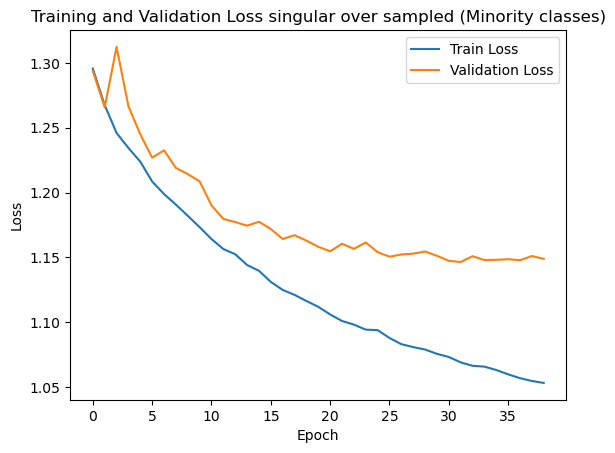

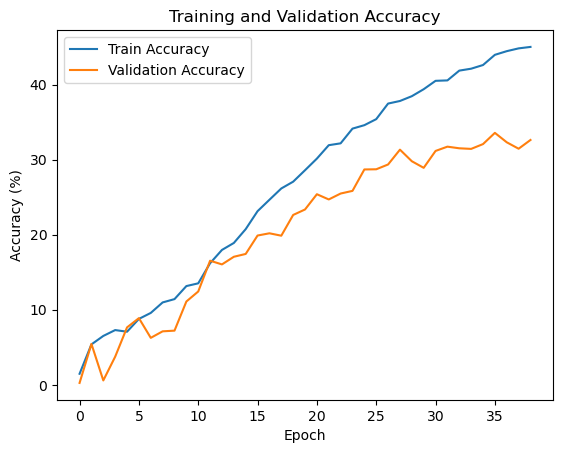

    Epoch  Train Loss  Train Accuracy  Val Loss  Val Accuracy
0       1    1.295535        1.470671  1.293697      0.251256
1       2    1.267453        5.386856  1.265632      5.447693
2       3    1.245917        6.512970  1.312248      0.582458
3       4    1.234390        7.294526  1.266499      3.746003
4       5    1.223817        7.076027  1.244871      7.651896
5       6    1.208520        8.782005  1.226883      8.885336
6       7    1.198833        9.580369  1.232546      6.258566
7       8    1.190703       10.978206  1.218997      7.126542
8       9    1.182091       11.420808  1.214224      7.217908
9      10    1.173337       13.157600  1.208663     11.100959
10     11    1.164176       13.524567  1.190070     12.437186
11     12    1.156442       16.205390  1.179658     16.537232
12     13    1.152471       17.975797  1.177253     16.046140
13     14    1.144151       18.903020  1.174436     17.062586
14     15    1.139678       20.746260  1.177511     17.439470
15     1

In [51]:
plt.plot(range(num_epochs_runned), train_losses, label="Train Loss")
plt.plot(range(num_epochs_runned), val_losses, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss singular over sampled (Minority classes)')
plt.show()

# Plot training and validation accuracy
plt.plot(range(num_epochs_runned), train_accuracies, label="Train Accuracy")
plt.plot(range(num_epochs_runned), val_accuracies, label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Save the results in a DataFrame for reporting
results_df = pd.DataFrame({
    'Epoch': range(1, num_epochs_runned + 1),
    'Train Loss': train_losses,
    'Train Accuracy': train_accuracies,
    'Val Loss': val_losses,
    'Val Accuracy': val_accuracies
})

print(results_df)